<a href="https://colab.research.google.com/github/Harish34272/Adaptive_feed/blob/sub-branch/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from joblib import load
import joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
BASE_DIR = Path("/content/drive/MyDrive/adaptive-feeding/combined_csv")
OUT_DIR  = BASE_DIR / "preprocessing"
OUT_DIR.mkdir(exist_ok=True, parents=True)

In [26]:
COST_COL = "Cost/kg"
ANIMALS = {
    "Fish": {
        "energy_cols": ["DE salmonids kcal/kg", "DE salmonids MJ/kg"],
        "percent_cols": ["ND salmonids %", "ED salmonids %"],
        "mass_cols": []
    },
    "Pig": {
        "energy_cols": [
            "DE growing pig kcal/kg", "ME growing pig kcal/kg", "NE growing pig kcal/kg",
            "DE adult pig kcal/kg",   "ME adult pig kcal/kg",   "NE adult pig kcal/kg",
            "DE growing pig MJ/kg"
        ],
        "percent_cols": [],
        "mass_cols": []
    },
    "Poultry": {
        "energy_cols": [
            "AMEn cockerel kcal/kg", "AMEn broiler kcal/kg",
            "AMEn cockerel MJ/kg",   "AMEn broiler MJ/kg",
            "AMEn cockerel ground kcal/kg" , "AMEn cockerel pelleted kcal/kg",
            "AMEn broiler ground kcal/kg" , "AMEn broiler pelleted kcal/kg"
        ],
        "percent_cols": [],
        "mass_cols": ["Avail. P cockerel g/kg", "Avail. P broiler g/kg"]

    },
    "Rabbit": {
        "energy_cols": [
            "DE (kcal) kcal/kg", "ME rabbit kcal/kg",
            "DE rabbit MJ/kg",   "ME rabbit MJ/kg"
        ],
        "percent_cols": ["ND rabbit %", "ED rabbit %"],
        "mass_cols": []
    },
    }


In [27]:
MJ_TO_KCAL = 239.005736
TEST_SIZE = 0.1
VAL_SIZE = 0.1
TRAIN_SIZE = 0.8
RNG = 42

In [28]:
dirs = [OUT_DIR, OUT_DIR / "train", OUT_DIR / "test" , OUT_DIR/"val" , OUT_DIR/"scalers"]
for d in dirs:
    d.mkdir(exist_ok=True, parents=True)

In [29]:
def preprocess(df:pd.DataFrame , energy_cols , percent_cols , mass_cols , cost_col):
    feat = df[energy_cols + percent_cols +mass_cols+ [cost_col]].copy()

    #converting MJ to KCAL
    mj_cols = [c for c in energy_cols if "MJ" in c]
    feat[mj_cols] = feat[mj_cols] * MJ_TO_KCAL

    #convert percent to decimals(0-1)
    feat[percent_cols] = feat[percent_cols]/100.0

    mask = feat.notnull().astype(int)
    mask_cols = [f"{c}_mask" for c in feat.columns]
    mask.columns = mask_cols
    feat = feat.fillna(0)

    energy_pipe = StandardScaler()
    feat[energy_cols] = energy_pipe.fit_transform(feat[energy_cols])

    mass_pipe = None
    if mass_cols:
        mass_pipe = Pipeline([('Standard Scaler', StandardScaler())])
        feat[mass_cols] = mass_pipe.fit_transform(feat[mass_cols])

    cost_pipe = Pipeline([('Standard Scaler', StandardScaler())])
    feat[cost_col] = cost_pipe.fit_transform(feat[[cost_col]])
    out = pd.concat([feat , mask] , axis = 1)
    scalers = {'energy': energy_pipe, 'mass': mass_pipe, 'cost': cost_pipe}
    return out, scalers

In [30]:
all_data = {}
for animal, specs in ANIMALS.items():
    dfs = []
    for csv_file in sorted(BASE_DIR.glob("*_combined1.csv")):
        df = pd.read_csv(csv_file)
        df.columns = df.columns.str.strip()
        df = df[df["Animal"] == animal]
        dfs.append(df)
    full_df = pd.concat(dfs, ignore_index=True)

    # Preprocess features
    X_scaled, scalers = preprocess(
        full_df, specs["energy_cols"], specs["percent_cols"], specs["mass_cols"] , COST_COL
    )
    # Replace raw with scaled for selected cols
    cols_to_replace = specs["energy_cols"] + specs["percent_cols"] + specs["mass_cols"] + [COST_COL]
    full_df.loc[:, cols_to_replace] = X_scaled[cols_to_replace]


    # Select final columns
    cols = ["Animal", "Feed Category", "Feed"] + specs["energy_cols"] + specs["percent_cols"] + specs["mass_cols"] + [COST_COL]
    processed_df = full_df[cols]
    all_data[animal] = processed_df

    # Save processed
    processed_df.to_csv(OUT_DIR / f"{animal}_processed.csv", index=False)
    print(f"Saved processed: {animal} ({len(processed_df)} rows)")


Saved processed: Fish (153 rows)
Saved processed: Pig (125 rows)
Saved processed: Poultry (118 rows)
Saved processed: Rabbit (125 rows)


In [31]:
from sklearn.model_selection import train_test_split

def safe_stratified_split(df, strat_col, test_size, random_state):
    vc = df[strat_col].value_counts()
    if (vc < 2).any():
        # too few for proper stratify: do random split
        return train_test_split(df, test_size=test_size,
                                random_state=random_state,
                                shuffle=True)
    else:
        return train_test_split(df, test_size=test_size,
                                random_state=random_state,
                                stratify=df[strat_col])


In [32]:
from sklearn.model_selection import train_test_split

for animal, df in all_data.items():
    stratify_col = df['Feed Category']  if df['Feed Category'].nunique() > 1 else None

    # First split: train (80%) vs temp (20%)
    train_df, temp_df = safe_stratified_split(
        df, 'Feed Category', test_size=TEST_SIZE+VAL_SIZE, random_state=RNG
    )
    val_df, test_df = safe_stratified_split(
        temp_df, 'Feed Category', test_size=0.5, random_state=RNG
    )
# Expand grouped scalers to column-wise mapping

    # Reset indices
    train_df.reset_index(drop=True, inplace=True)
    val_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)

    # Save splits
    train_df.to_csv(OUT_DIR / "train" / f"{animal}_train.csv", index=False)
    val_df.to_csv(OUT_DIR / "val" / f"{animal}_val.csv", index=False)
    test_df.to_csv(OUT_DIR / "test" / f"{animal}_test.csv", index=False)
    joblib.dump(scalers, OUT_DIR / "scalers" / f"{animal}_scalers.pkl")
    print(f"{animal}: {len(train_df)} train / {len(val_df)} val / {len(test_df)} test")


Fish: 122 train / 15 val / 16 test
Pig: 100 train / 12 val / 13 test
Poultry: 94 train / 12 val / 12 test
Rabbit: 100 train / 12 val / 13 test


/tmp/ipython-input-33-2651048353.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(mean_energy, labels=animals)


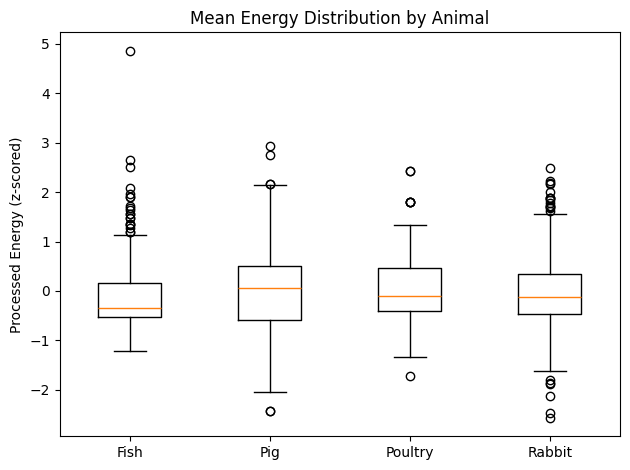

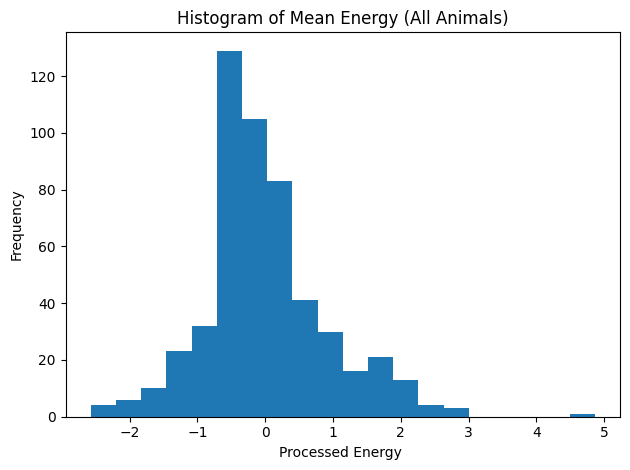

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Adjust this path to wherever you saved the processed CSVs
animals = ["Fish", "Pig", "Poultry", "Rabbit"]

# 1) BOXPLOT: compare the distribution of “mean energy” across animals
mean_energy = []
for animal in animals:
    df = pd.read_csv(OUT_DIR / f"{animal}_processed.csv")
    energy_cols = [c for c in df.columns if "kcal/kg" in c or "MJ/kg" in c]
    mean_energy.append(df[energy_cols].mean(axis=1))

plt.figure()
plt.boxplot(mean_energy, labels=animals)
plt.title("Mean Energy Distribution by Animal")
plt.ylabel("Processed Energy (z‑scored)")
plt.tight_layout()
plt.show()

# 2) HISTOGRAM: overall spread of mean energy values across all animals
all_means = pd.concat(mean_energy, ignore_index=True)
plt.figure()
plt.hist(all_means, bins=20)
plt.title("Histogram of Mean Energy (All Animals)")
plt.xlabel("Processed Energy ")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def detect_outliers_iqr(df, cols, animal_name, plot=True, iqr_range=1.5):
    outlier_info = {}

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_range * IQR
        upper_bound = Q3 + iqr_range * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_info[col] = {
            'num_outliers': len(outliers),
            'percent': 100 * len(outliers) / len(df),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

        if plot:
            plt.figure(figsize=(6, 2))
            plt.boxplot(df[col].dropna(), vert=False)
            plt.title(f"{animal_name} - {col} (Outliers: {len(outliers)})")
            plt.xlabel(col)
            plt.tight_layout()
            plt.show()

    return pd.DataFrame(outlier_info).T.sort_values("num_outliers", ascending=False)



=== Fish ===


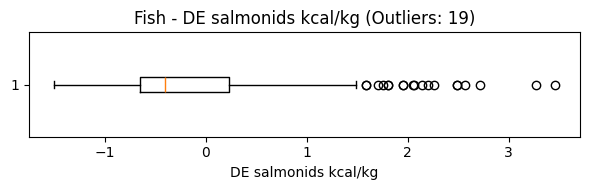

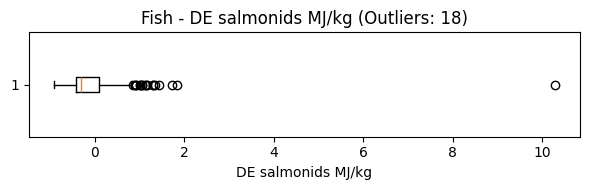

                      num_outliers    percent  lower_bound  upper_bound
DE salmonids kcal/kg          19.0  12.418301    -1.960931     1.548317
DE salmonids MJ/kg            18.0  11.764706    -1.181395     0.850902

=== Pig ===


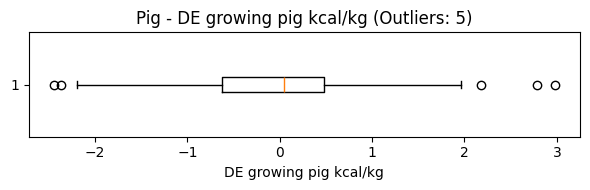

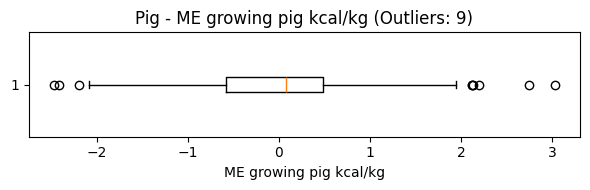

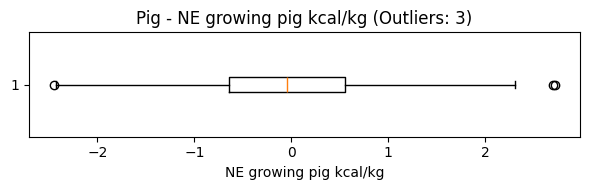

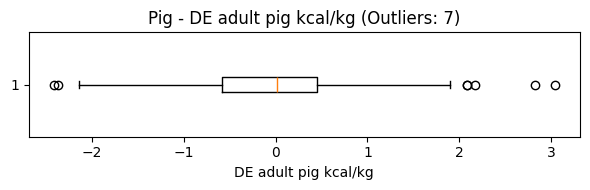

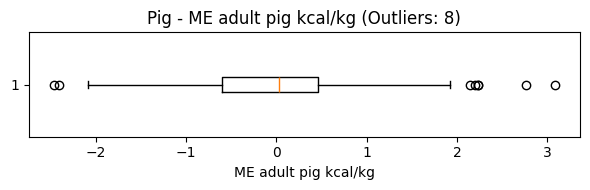

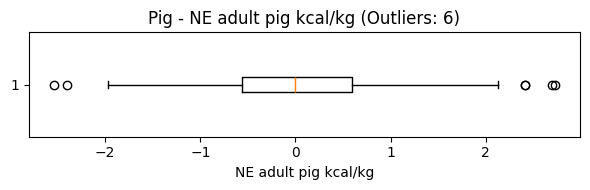

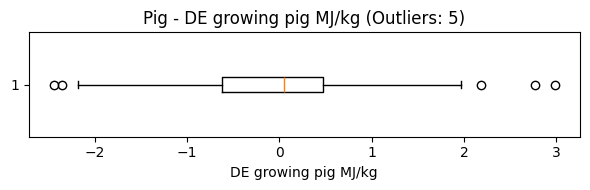

                        num_outliers  percent  lower_bound  upper_bound
ME growing pig kcal/kg           9.0      7.2    -2.182403     2.075245
ME adult pig kcal/kg             8.0      6.4    -2.182946     2.047395
DE adult pig kcal/kg             7.0      5.6    -2.134296     1.995933
NE adult pig kcal/kg             6.0      4.8    -2.300582     2.329821
DE growing pig kcal/kg           5.0      4.0    -2.282779     2.129579
DE growing pig MJ/kg             5.0      4.0    -2.254381     2.109059
NE growing pig kcal/kg           3.0      2.4    -2.425039     2.333049

=== Poultry ===


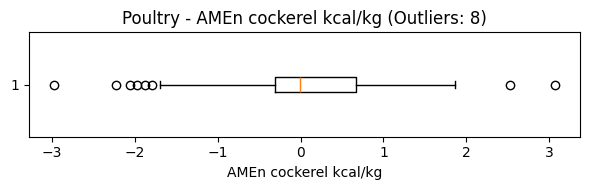

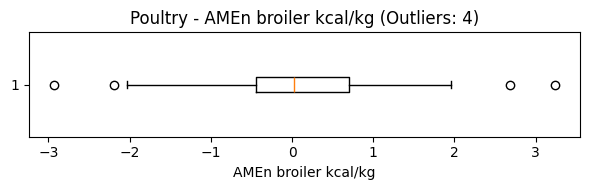

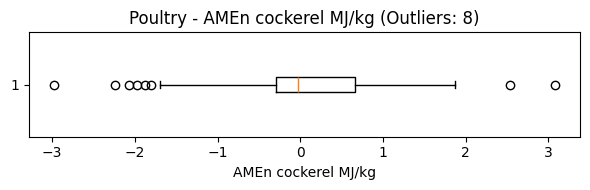

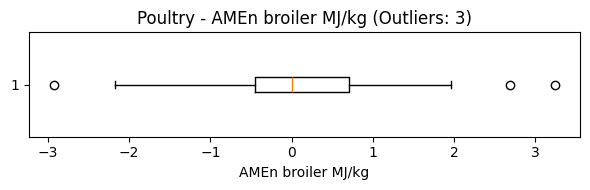

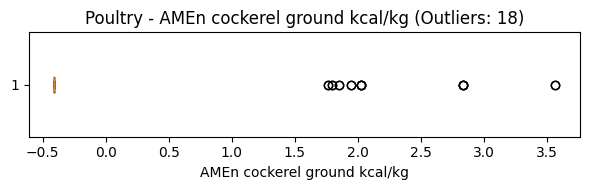

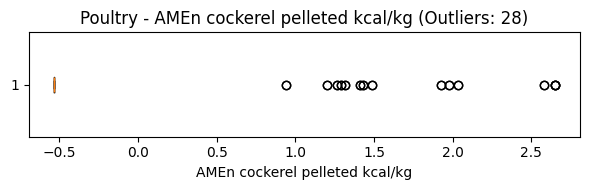

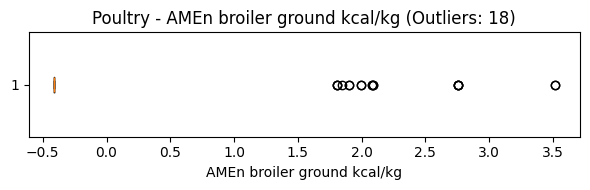

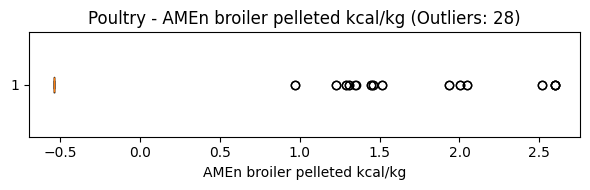

                                num_outliers    percent  lower_bound  \
AMEn broiler pelleted kcal/kg           28.0  23.728814    -0.539090   
AMEn cockerel pelleted kcal/kg          28.0  23.728814    -0.536820   
AMEn broiler ground kcal/kg             18.0  15.254237    -0.414423   
AMEn cockerel ground kcal/kg            18.0  15.254237    -0.412644   
AMEn cockerel MJ/kg                      8.0   6.779661    -1.737265   
AMEn cockerel kcal/kg                    8.0   6.779661    -1.764129   
AMEn broiler kcal/kg                     4.0   3.389831    -2.168115   
AMEn broiler MJ/kg                       3.0   2.542373    -2.183823   

                                upper_bound  
AMEn broiler pelleted kcal/kg     -0.539090  
AMEn cockerel pelleted kcal/kg    -0.536820  
AMEn broiler ground kcal/kg       -0.414423  
AMEn cockerel ground kcal/kg      -0.412644  
AMEn cockerel MJ/kg                2.105510  
AMEn cockerel kcal/kg              2.124004  
AMEn broiler kcal/kg         

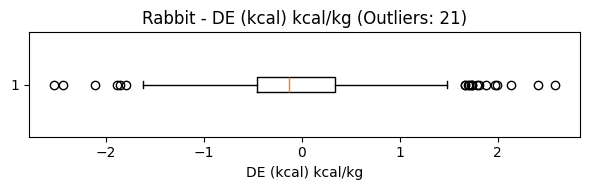

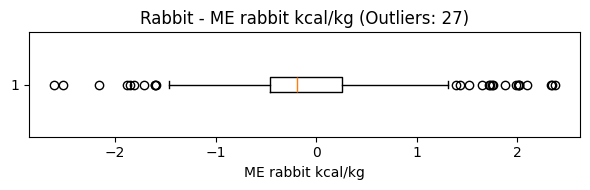

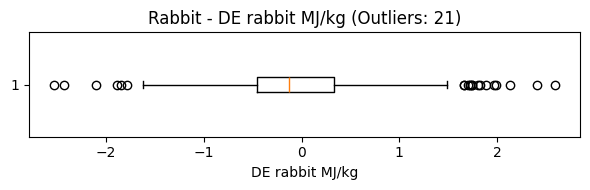

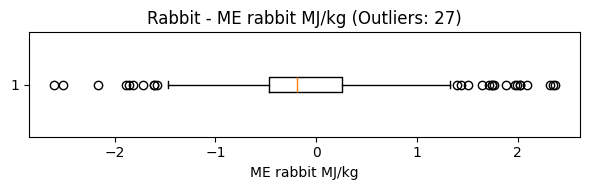

                   num_outliers  percent  lower_bound  upper_bound
ME rabbit kcal/kg          27.0     21.6    -1.523923     1.317547
ME rabbit MJ/kg            27.0     21.6    -1.547033     1.334194
DE (kcal) kcal/kg          21.0     16.8    -1.642764     1.520475
DE rabbit MJ/kg            21.0     16.8    -1.642528     1.512029


In [13]:
for animal, df in all_data.items():
    energy_cols = ANIMALS[animal]['energy_cols']
    print(f"\n=== {animal} ===")
    outlier_stats = detect_outliers_iqr(df, energy_cols, animal)
    print(outlier_stats)


In [14]:
def detect_outliers_iqr(df, cols, iqr_range=1.5):
    outlier_info = {}

    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - iqr_range * IQR
        upper = Q3 + iqr_range * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]
        outlier_info[col] = {
            'outliers': len(outliers),
            'percent': round(100 * len(outliers) / len(df), 2),
            'lower_bound': round(lower, 3),
            'upper_bound': round(upper, 3)
        }

    return pd.DataFrame(outlier_info).T.sort_values("outliers", ascending=False)


In [15]:
for animal, df in all_data.items():
    energy_cols = ANIMALS[animal]['energy_cols']
    print(f"\n=== Outliers in {animal} ===")
    stats = detect_outliers_iqr(df, energy_cols)
    print(stats)



=== Outliers in Fish ===
                      outliers  percent  lower_bound  upper_bound
DE salmonids kcal/kg      19.0    12.42       -1.961        1.548
DE salmonids MJ/kg        18.0    11.76       -1.181        0.851

=== Outliers in Pig ===
                        outliers  percent  lower_bound  upper_bound
ME growing pig kcal/kg       9.0      7.2       -2.182        2.075
ME adult pig kcal/kg         8.0      6.4       -2.183        2.047
DE adult pig kcal/kg         7.0      5.6       -2.134        1.996
NE adult pig kcal/kg         6.0      4.8       -2.301        2.330
DE growing pig kcal/kg       5.0      4.0       -2.283        2.130
DE growing pig MJ/kg         5.0      4.0       -2.254        2.109
NE growing pig kcal/kg       3.0      2.4       -2.425        2.333

=== Outliers in Poultry ===
                                outliers  percent  lower_bound  upper_bound
AMEn broiler pelleted kcal/kg       28.0    23.73       -0.539       -0.539
AMEn cockerel pelleted kca